In [1]:
import matplotlib.pyplot as plt
import twodlearn as tdl
import twodlearn.tests.bayesnet_test
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

In [2]:
uncertainty = 'heteroscedastic'
dataset = tdl.tests.bayesnet_test.create_heteroscedastic_dataset()
#dataset = tdl.tests.bayesnet_test.create_homoscedastic_dataset()

Data set created, shape:  (1000,)


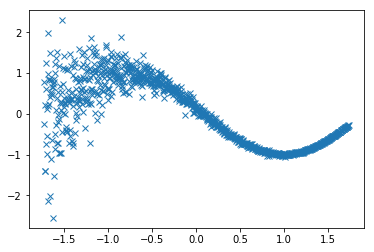

In [3]:
plt.plot(dataset.train.x, dataset.train.y, 'x')

In [4]:
def homoscedastic():
    return tdl.bayesnet.NormalModel(
        batch_shape=[None, 1],
        loc=tdl.stacked.StackedLayers(
            layers=[tdl.bayesnet.AffineNormalLayer(units=10, tolerance=1e-5),
                    tf.keras.activations.softplus,
                    tdl.bayesnet.AffineNormalLayer(units=1, tolerance=1e-5)]))

def heteroscedastic():
    return tdl.bayesnet.NormalModel(
        batch_shape=[None, 1],
        loc=tdl.stacked.StackedLayers(
            layers=[tdl.bayesnet.AffineNormalLayer(units=20, tolerance=1e-5),
                    tf.keras.layers.LeakyReLU(),
                    tf.keras.layers.Dropout(rate=0.1),
                    tdl.bayesnet.AffineNormalLayer(units=20, tolerance=1e-5),
                    tf.keras.layers.Activation(tf.nn.softplus),
                    tf.keras.layers.Dropout(rate=0.1),
                    tdl.bayesnet.AffineNormalLayer(units=1, tolerance=1e-5)]),
        scale=tdl.stacked.StackedLayers(
            layers=[tdl.bayesnet.AffineNormalLayer(units=20, tolerance=1e-5),
                    tf.keras.layers.Activation(tf.nn.softplus),
                    tdl.bayesnet.AffineNormalLayer(units=1, tolerance=1e-5),
                    tf.keras.layers.Activation(tf.nn.softplus),
                    lambda x: x+1e-3])
    )

def get_model(dataset, uncertainty):
    if uncertainty == 'homoscedastic':
        model = homoscedastic()    
    elif uncertainty == 'heteroscedastic':
        model = heteroscedastic()
    labels = tf.placeholder(tf.float32, (None, 1))
    inputs = tf.placeholder(tf.float32, (None, 1))
    outputs = model(inputs)
    # loss
    kernel_prior = tfp.distributions.Normal(loc=0.0, scale=1.0)
    kl = [tfp.distributions.kl_divergence(kernel, kernel_prior)
          for kernel in [layer.kernel for layer in model.loc.layers
                         if isinstance(layer, tdl.bayesnet.AffineNormalLayer)]]
    try:
        kernel_prior = tfp.distributions.Normal(loc=0.0, scale=1.0)
        kl.update([tfp.distributions.kl_divergence(kernel, kernel_prior)
                   for kernel in [model.scale.layers[0].kernel,
                                  model.scale.layers[2].kernel]])
    except AttributeError:
        pass
    log_prob = tf.reduce_mean(tf.reduce_sum(outputs.log_prob(labels), -1),
                              axis=0)
    kl = tf.add_n([tf.reduce_sum(kl_i) for kl_i in kl])
    train = tdl.core.SimpleNamespace(
        inputs=inputs,
        outputs=outputs,
        loss=-log_prob + (1.0/dataset.train.n_samples)*kl,
        labels=labels)

    # Test model
    test_inputs = tf.placeholder(shape=(None, 1), dtype=tf.float32)
    test_model = tdl.stacked.StackedLayers(
        layers=[tdl.bayesnet.ParticlesLayer(particles=500),
                tdl.bayesnet.SampleLayer(distribution=model),
                tdl.bayesnet.McNormalEstimate()]) 
    test_outputs = outputs=test_model(test_inputs)
    test = tdl.core.SimpleNamespace(
        model=test_model,
        inputs=test_inputs,
        outputs=test_outputs,
        samples=test_outputs.sample()
        )

    return tdl.core.SimpleNamespace(model=model, train=train, test=test)


In [5]:
estimator = get_model(dataset, uncertainty)


/home/marinodl/research/2019/AssociativeGAN/env/lib/python3.5/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [6]:
cell = estimator.model

In [7]:
import twodlearn.recurrent
test = tdl.recurrent.concat_wrapper(cell)

In [8]:
test.call()

<function twodlearn.bayesnet.bayesnet.NormalModel.call(self, inputs, *args, **kargs)>

In [16]:
isinstance(estimator.model, tdl.core.Layer)

True

In [ ]:
tf.keras.layers.RNN.get_initial_state

In [6]:
optim = tdl.optim.Optimizer(
    loss=estimator.train.loss, 
    var_list=tdl.core.get_trainable(estimator.model),
    log_folder='tmp/',
    learning_rate=0.01)
tdl.core.initialize_variables(estimator.model)

In [7]:
optim.run(feed_train=
            lambda:{estimator.train.labels: dataset.train.y[..., np.newaxis],
                    estimator.train.inputs: dataset.train.x[..., np.newaxis]},
          n_train_steps=3000)

100 | [('train/loss', 1.674335489273071)] | []
200 | [('train/loss', 0.8529307901859292)] | []
300 | [('train/loss', 0.5774096608161937)] | []
nan
checkpoint created
400 | [('train/loss', 0.5134591645002381)] | []
500 | [('train/loss', 0.4840247881412521)] | []
600 | [('train/loss', 0.46937009841203836)] | []
0.033690273541503314
checkpoint created
700 | [('train/loss', 0.4575872486829773)] | []
800 | [('train/loss', 0.4443215492367759)] | []
900 | [('train/loss', 0.4258911404013649)] | []
1000 | [('train/loss', 0.3939533409476295)] | []
0.027304096838844764
checkpoint created
1100 | [('train/loss', 0.3688044187426582)] | []
1200 | [('train/loss', 0.3565397980809227)] | []
1300 | [('train/loss', 0.3462188509106651)] | []
0.015360313520388592
checkpoint created
1400 | [('train/loss', 0.33849084496498255)] | []
1500 | [('train/loss', 0.33147796005010755)] | []
1600 | [('train/loss', 0.32326869189739377)] | []
1700 | [('train/loss', -0.09733844287693341)] | []
0.1738417717106215
checkpoin

In [8]:
session = tf.get_default_session()
test_x = np.linspace(-2.0, 5.0, 100)
loc, scale = session.run([estimator.train.outputs.loc, 
                          estimator.train.outputs.scale], 
            feed_dict={estimator.train.inputs: test_x[..., np.newaxis]})

test_mean, test_stddev, test_samples = session.run(
    [estimator.test.outputs.loc, estimator.test.outputs.scale, estimator.test.samples], 
    feed_dict={estimator.test.inputs: test_x[..., np.newaxis]})

In [9]:
estimator.test.model.layers

In [10]:
#test = session.run({'loc': output.loc, 
#                          'scale':output.scale}, 
#            feed_dict={inputs: test_x[..., np.newaxis]})


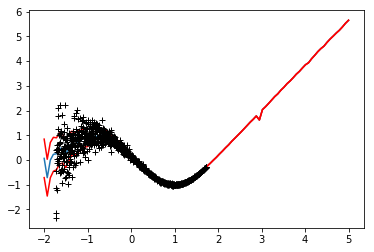

In [11]:
plt.plot(test_x, loc)
plt.plot(test_x, loc+scale, 'r')
plt.plot(test_x, loc-scale, 'r')
plt.plot(dataset.train.x, dataset.train.y, '+k')

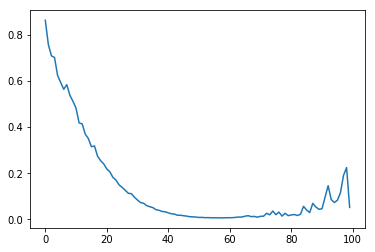

In [12]:
plt.plot(np.squeeze(test_stddev)[:])

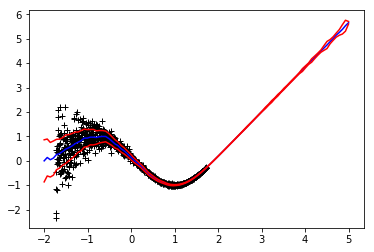

In [13]:
plt.plot(dataset.train.x, dataset.train.y, '+k')
plt.plot(test_x, np.squeeze(test_mean), 'b')
plt.plot(test_x, np.squeeze(test_mean) + np.squeeze(test_stddev), 'r')
plt.plot(test_x, np.squeeze(test_mean) - np.squeeze(test_stddev), 'r')


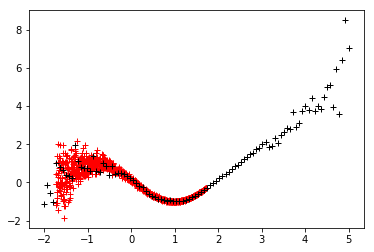

In [41]:
plt.plot(dataset.train.x, dataset.train.y, '+r')
plt.plot(test_x, np.squeeze(test_samples), '+k')

In [26]:
estimator.model.loc.layers[0].kernel.scale.eval()

array([[0.01076472, 0.01131402, 0.01076885, 0.01068806, 0.01162645,
        0.00983851, 0.01067827, 0.01146807, 0.01011505, 0.00463569,
        0.00083018, 0.00081005, 0.01087074, 0.01141055, 0.01151509,
        0.01140737, 0.01087592, 0.00928579, 0.01100221, 0.0115376 ]],
      dtype=float32)

In [304]:
tf.broadcast_static_shape(tf.TensorShape([10, None, 100]), tf.TensorShape([1, 100]))

TensorShape([Dimension(10), Dimension(None), Dimension(100)])

In [184]:
class TestLayer(tdl.core.Layer):
    def call(self, inputs, state):
        return tf.concat([inputs, state], -1)


#model = TestLayer()
#model = tf.keras.layers.LSTMCell(units=20)
model = tf.keras.layers.Concatenate()

In [186]:
import twodlearn.debug

@tdl.debug.stop_at_error
def test():
    #return model(tf.placeholder(tf.float32, (None, 3)),
    #             model.get_initial_state(batch_size=20, dtype=tf.float32))
    return model([tf.placeholder(tf.float32, (None, 3)),
                  tf.placeholder(tf.float32, (None, 5))])

output = test()

In [190]:
output

<tf.Tensor 'concatenate_1/concat:0' shape=(?, 8) dtype=float32>

In [189]:
model.output_shape

AttributeError: The layer has never been called and thus has no defined output shape.

In [236]:
class NormalModel(tdl.core.Layer):
    @tdl.core.InputArgument
    def input_shape(self, value):
        if value is None:
            raise tdl.core.exceptions.ArgumentNotProvided(self)
        if not isinstance(value, tf.TensorShape):
            value = tf.TensorShape(value)
        return value
        
    @tdl.core.InputArgument
    def batch_shape(self, value):
        if value is None:
            raise tdl.core.exceptions.ArgumentNotProvided(self)
        if not isinstance(value, tf.TensorShape):
            value = tf.TensorShape(value)
        return value

    @tdl.core.SubmodelInit
    def loc(self, initializer=None, trainable=True, **kargs):
        tdl.core.assert_initialized(self, 'loc', ['batch_shape'])
        if initializer is None:
            initializer = tf.keras.initializers.zeros()
        shape = tf.TensorShape(
            (1 if dim is None else dim)
            for dim in self.batch_shape.as_list())
        return self.add_weight(
            name='loc',
            initializer=initializer,
            shape=shape,
            trainable=trainable,
            **kargs)

    @tdl.core.SubmodelInit
    def scale(self, initializer=None, trainable=True, **kargs):
        tdl.core.assert_initialized(self, 'shape', ['batch_shape'])
        shape = tf.TensorShape(
            (1 if dim is None else dim)
            for dim in self.batch_shape.as_list())
        if initializer is None:
            initializer = tdl.constrained.PositiveVariableExp.init_wrapper(
                initializer=tf.keras.initializers.ones(),
                trainable=trainable,
                tolerance=1e-5,
                **kargs)
        return initializer(shape=shape)

    def build(self, input_shape=None):
        tdl.core.assert_initialized(self, 'build', ['loc', 'scale'])
        if input_shape is not None and not tdl.core.is_property_initialized(self, 'input_shape'):
            self.input_shape = input_shape
        self.built = True

    def call(self, inputs, *args, **kargs):
        if inputs is not None:
            inputs = tf.convert_to_tensor(inputs)
        loc = (self.loc(inputs) if callable(self.loc)
               else self.loc)
        scale = (self.scale(inputs) if callable(self.scale)
                 else self.scale)
        return tfp.distributions.Normal(loc=loc, scale=scale)

In [237]:
model = NormalModel(
        batch_shape=[None, 1],
        loc=tdl.stacked.StackedLayers(
            layers=[tdl.bayesnet.AffineNormalLayer(units=10, tolerance=1e-5),
                    tf.keras.activations.softplus,
                    tdl.bayesnet.AffineNormalLayer(units=1, tolerance=1e-5)]))

In [238]:
@tdl.debug.stop_at_error
def test():
    inputs = tf.placeholder(tf.float32, (None, 1))
    return model(inputs)
outputs = test()

In [244]:
outputs

<tfp.distributions.Normal 'NormalModel_10_1/Normal/' batch_shape=(?, 1) event_shape=() dtype=float32>

In [242]:
model.input_shape

TensorShape([Dimension(None), Dimension(1)])

In [243]:
model.batch_shape

TensorShape([Dimension(None), Dimension(1)])